                x          y  elevation
0       64.155956   0.000000    -2304.4
1       64.155956   0.115958    -2298.2
2       64.155956   0.231917    -2287.0
3       64.155956   0.347875    -2267.4
4       64.155956   0.463833    -2240.0
...           ...        ...        ...
431329   0.000000  89.056000    -1004.4
431330   0.000000  89.171958    -1018.6
431331   0.000000  89.287917    -1029.6
431332   0.000000  89.403875    -1035.4
431333   0.000000  89.519833    -1035.0

[431334 rows x 3 columns]


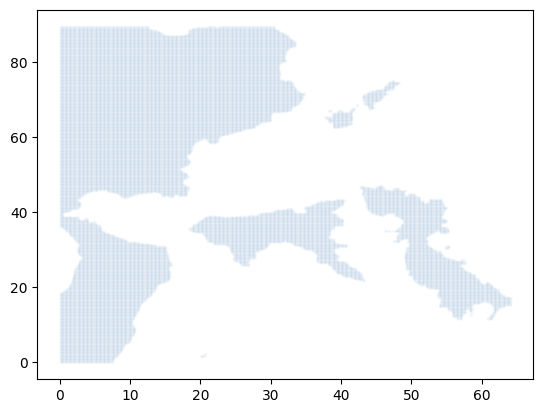

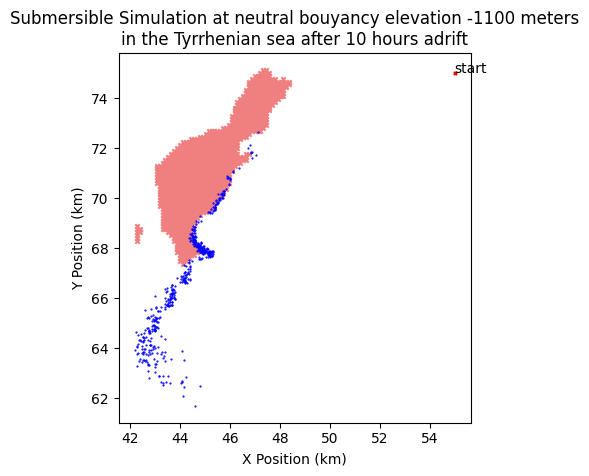

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

class Submersible:
    def __init__(self, position, movement_direction, neutral_buoyancy_elevation):
        self.position = np.array(position, dtype=float)
        self.movement_direction = np.array(movement_direction, dtype=float)
        self.movement_direction /= np.linalg.norm(movement_direction)
        self.neutral_buoyancy_elevation = neutral_buoyancy_elevation

    def step(self, ocean_depth_matrix, ocean_current_direction, ocean_current_variance, is_stuck):
        if is_stuck:return
        k = get_closest_elevation(ocean_depth_matrix, self.position[0], self.position[1])
        if k > self.neutral_buoyancy_elevation:
            is_stuck = True
            return is_stuck  # Do not move if depth is higher than neutral buoyancy
        elif k > self.neutral_buoyancy_elevation -20:
            if random.random() > (max(neutral_buoyancy_elevation-k,0)/20)**2:
              is_stuck = True
              return is_stuck

        # Add ocean current direction and normalize
        mean_movement_direction = (self.movement_direction + ocean_current_direction).astype(float)
        mean_movement_direction /= np.linalg.norm(mean_movement_direction)

        # Sample from Gaussian unit vector distribution
        new_movement_direction = np.random.normal(mean_movement_direction, ocean_current_variance)
        new_movement_direction /= np.linalg.norm(new_movement_direction)

        # Update position and movement direction
        self.position += new_movement_direction*.15
        self.movement_direction = new_movement_direction

        return is_stuck

def run_simulation(num_simulations, num_steps, ocean_depth_matrix, ocean_current_direction, ocean_current_variance, neutral_buoyancy_elevation):
    all_simulation_positions = []
    for _ in range(num_simulations):
        submersible = Submersible(position=[55.0, 75.0], movement_direction=[-0.4, -.3], neutral_buoyancy_elevation=neutral_buoyancy_elevation)
        simulation_positions = []
        is_stuck = False
        for step in range(num_steps):
            if (not is_stuck):
              is_stuck = submersible.step(ocean_depth_matrix, ocean_current_direction, ocean_current_variance, is_stuck)

            # Record position every predetermined amount of steps
            if step == (10*12) :
                simulation_positions.append(submersible.position.copy())
        all_simulation_positions.append(simulation_positions)

    return all_simulation_positions

def plot_simulation_positions(simulation_positions, above_neutral_pts, neutral_buoyancy_elevation):
    x_min = 10000
    y_min = 10000
    for positions in simulation_positions:
        x_vals = [pos[0] for pos in positions]
        y_vals = [pos[1] for pos in positions]
        if min(x_vals)<x_min:
          x_min=min(x_vals)
        if min(y_vals)<y_min:
          y_min=min(y_vals)

        # Plot submarine positions
        plt.scatter(x_vals, y_vals, color = 'blue',s=.3)

    #for positions in stuck_simulation_positions:
    #    x_stuck_vals = [pos[0] for pos in positions]
    #    y_stuck_vals = [pos[1] for pos in positions]
    #    plt.scatter(x_stuck_vals,y_stuck_vals, color = 'black', s =.3)


        # Plot red X where ocean floor depth is less than neutral buoyancy
    above_neutral_pts = above_neutral_pts[above_neutral_pts['x']>x_min]
    above_neutral_pts = above_neutral_pts[above_neutral_pts['y']>y_min]
    plt.scatter(above_neutral_pts['x'], above_neutral_pts['y'], color = 'lightcoral', marker = 'x', s=10, zorder = 0)

    plt.xlabel('X Position (km)')
    plt.ylabel('Y Position (km)')
    plt.scatter([55],[75.0], marker = 'x', color = 'red', s=5)
    plt.text(55.0,75.0,'start')
    plt.title('Submersible Simulation at neutral bouyancy elevation ' + str(neutral_buoyancy_elevation)+' meters\nin the Tyrrhenian sea after 10 hours adrift')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()





import pandas as pd
from scipy.spatial import cKDTree


csv_file_path = '/content/Depth3.csv'
df = pd.read_csv(csv_file_path)
df = df.astype(float)
df['y']=max(df['y'])-df['y']
print(df)

coordinates = df[['x', 'y']].values
kdtree = cKDTree(coordinates)

def get_closest_elevation(df, x, y):
    query_point = [x, y]
    _, index = kdtree.query(query_point)

    closest_elevation = df.loc[index, 'elevation']

    return closest_elevation




num_simulations = 500
num_steps = 24*12+1 #represents number of 5 minute steps the simulation takes
ocean_depth_matrix = df
ocean_current_direction = np.array([-0.4, -0.3])
ocean_current_variance = .3
neutral_buoyancy_elevation = -1100

above_neutral_pts = df[df['elevation']>neutral_buoyancy_elevation]
#above_neutral_pts['y'] = max(above_neutral_pts['y'])-above_neutral_pts['y']
plt.scatter(above_neutral_pts['x'],above_neutral_pts['y'],s=.0001)
plt.show()





simulation_positions = run_simulation(num_simulations, num_steps, df, ocean_current_direction, ocean_current_variance, neutral_buoyancy_elevation)
plot_simulation_positions(simulation_positions, above_neutral_pts, neutral_buoyancy_elevation)





                x          y    elevation
0        0.000000   0.000000 -3489.000000
1        0.108568   0.000000 -3480.000000
2        0.217137   0.000000 -3457.800000
3        0.325705   0.000000 -3436.000000
4        0.434273   0.000000 -3438.600000
...           ...        ...          ...
592011  98.037231  74.982994  -101.098190
592012  98.145799  74.982994  -100.793100
592013  98.254367  74.982994  -100.503840
592014  98.362936  74.982994  -100.230064
592015  98.471504  74.982994   -99.924000

[592016 rows x 3 columns]


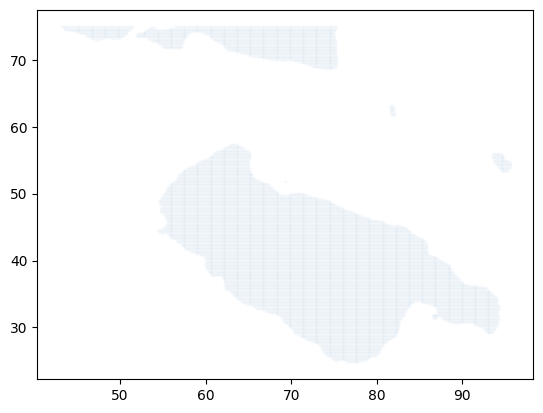

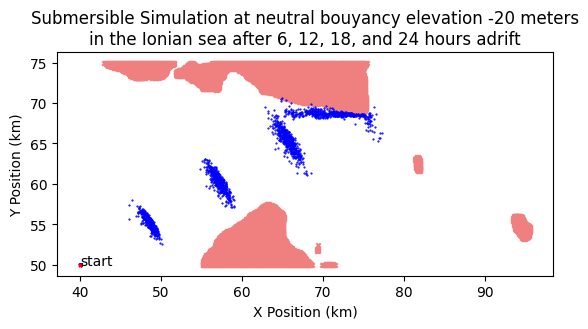

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

class Submersible:
    def __init__(self, position, movement_direction, neutral_buoyancy_elevation):
        self.position = np.array(position, dtype=float)
        self.movement_direction = np.array(movement_direction, dtype=float)
        self.movement_direction /= np.linalg.norm(movement_direction)
        self.neutral_buoyancy_elevation = neutral_buoyancy_elevation

    def step(self, ocean_depth_matrix, ocean_current_direction, ocean_current_variance, is_stuck):
        if is_stuck:return
        k = get_closest_elevation(ocean_depth_matrix, self.position[0], self.position[1])
        if k > self.neutral_buoyancy_elevation:
            is_stuck = True
            return is_stuck  # Do not move if depth is higher than neutral buoyancy
        elif k > self.neutral_buoyancy_elevation -20:
            if random.random()**2 > (max(neutral_buoyancy_elevation-k,0)/20):
              is_stuck = True
              return is_stuck

        # Add ocean current direction and normalize
        mean_movement_direction = (self.movement_direction + ocean_current_direction).astype(float)
        mean_movement_direction /= np.linalg.norm(mean_movement_direction)

        # Sample from Gaussian unit vector distribution
        new_movement_direction = np.random.normal(mean_movement_direction, ocean_current_variance)
        new_movement_direction /= np.linalg.norm(new_movement_direction)

        # Update position and movement direction
        self.position += new_movement_direction*.15
        self.movement_direction = new_movement_direction

        return is_stuck

def run_simulation(num_simulations, num_steps, ocean_depth_matrix, ocean_current_direction, ocean_current_variance, neutral_buoyancy_elevation):
    all_simulation_positions = []
    for _ in range(num_simulations):
        submersible = Submersible(position=[40.0, 50.0], movement_direction=[0.5, 0.25], neutral_buoyancy_elevation=neutral_buoyancy_elevation)
        simulation_positions = []
        is_stuck = False
        for step in range(num_steps):
            if (not is_stuck):
              is_stuck = submersible.step(ocean_depth_matrix, ocean_current_direction, ocean_current_variance, is_stuck)

            # Record position every predetermined amount of steps
            if (step % (6*12)) == 0 :
                simulation_positions.append(submersible.position.copy())
        all_simulation_positions.append(simulation_positions)

    return all_simulation_positions

def plot_simulation_positions(simulation_positions, above_neutral_pts, neutral_buoyancy_elevation):
    x_min = 10000
    y_min = 10000
    for positions in simulation_positions:
        x_vals = [pos[0] for pos in positions]
        y_vals = [pos[1] for pos in positions]
        if min(x_vals)<x_min:
          x_min=min(x_vals)
        if min(y_vals)<y_min:
          y_min=min(y_vals)

        # Plot submarine positions
        plt.scatter(x_vals, y_vals, color = 'blue',s=.3)

    #for positions in stuck_simulation_positions:
    #    x_stuck_vals = [pos[0] for pos in positions]
    #    y_stuck_vals = [pos[1] for pos in positions]
    #    plt.scatter(x_stuck_vals,y_stuck_vals, color = 'black', s =.3)


        # Plot red X where ocean floor depth is less than neutral buoyancy
    above_neutral_pts = above_neutral_pts[above_neutral_pts['x']>x_min]
    above_neutral_pts = above_neutral_pts[above_neutral_pts['y']>y_min]
    plt.scatter(above_neutral_pts['x'], above_neutral_pts['y'], color = 'lightcoral', marker = 'x', s=10, zorder = 0)

    plt.xlabel('X Position (km)')
    plt.ylabel('Y Position (km)')
    plt.scatter([40.0],[50.0], marker = 'x', color = 'red', s=5)
    plt.text(40.0,50.0,'start')
    plt.title('Submersible Simulation at neutral bouyancy elevation ' + str(neutral_buoyancy_elevation)+' meters\nin the Ionian sea after 6, 12, 18, and 24 hours adrift')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()





import pandas as pd
from scipy.spatial import cKDTree

# Step 1: Read the CSV file
csv_file_path = '/content/Depth2.csv'
df = pd.read_csv(csv_file_path)
df = df.astype(float)
df['y']=max(df['y'])-df['y']
print(df)
# Step 2: Create a KDTree from x and y coordinates
coordinates = df[['x', 'y']].values
kdtree = cKDTree(coordinates)

# Step 3: Define a function to get the closest elevation for a given x, y coordinate
def get_closest_elevation(df, x, y):
    query_point = [x, y]
    _, index = kdtree.query(query_point)

    # Retrieve the elevation from the closest point
    closest_elevation = df.loc[index, 'elevation']

    return closest_elevation




num_simulations = 500
num_steps = 24*12+1 #represents number of 5 minute steps the simulation takes
ocean_depth_matrix = df
ocean_current_direction = np.array([0.5, 0.3])
ocean_current_variance = .3
neutral_buoyancy_elevation = -20

above_neutral_pts = df[df['elevation']>neutral_buoyancy_elevation]
#above_neutral_pts['y'] = max(above_neutral_pts['y'])-above_neutral_pts['y']
plt.scatter(above_neutral_pts['x'],above_neutral_pts['y'],s=.0001)
plt.show()





simulation_positions = run_simulation(num_simulations, num_steps, df, ocean_current_direction, ocean_current_variance, neutral_buoyancy_elevation)
plot_simulation_positions(simulation_positions, above_neutral_pts, neutral_buoyancy_elevation)
